# Starbucks Customer Segmentation

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [206]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Understading each dataset

### Profile Dataset

In [2]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [3]:
profile.shape, profile.id.nunique()

((17000, 5), 17000)

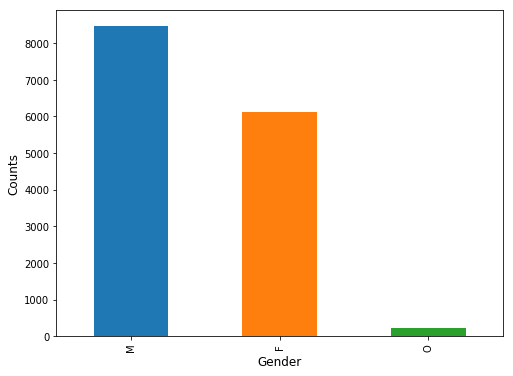

In [4]:
fig, ax = plt.subplots(figsize=(8,6))
profile.gender.value_counts().plot(kind='bar')
ax.set_xlabel("Gender", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);
plt.show()

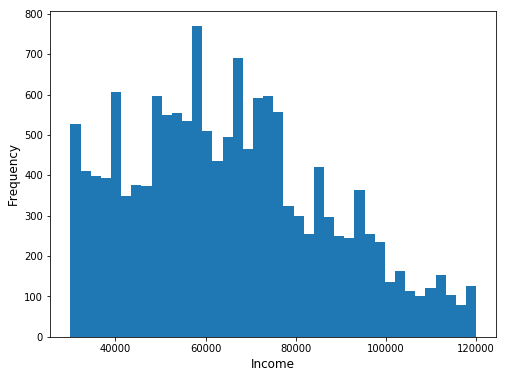

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
profile.income.plot(kind='hist', bins=40)
ax.set_xlabel("Income", fontsize=12);
ax.set_ylabel("Frequency", fontsize=12);
plt.show()

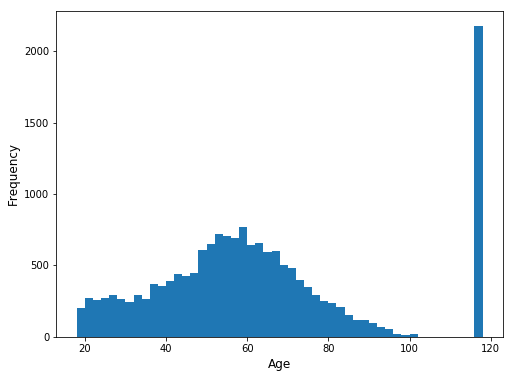

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
profile.age.plot(kind='hist', bins=50)
ax.set_xlabel("Age", fontsize=12);
ax.set_ylabel("Frequency", fontsize=12);
plt.show()

In [7]:
len(profile[profile.age > 100])

2180

In [8]:
profile.shape

(17000, 5)

In [9]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

We have more than 2000 records missing in income and age, and 2000 memmbers above 100 years old, are these the same records?

In [10]:
profile[profile.gender.isnull()].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


Same records have the missing age and gender

In [11]:
profile[profile.gender.isnull()].age.value_counts()

118    2175
Name: age, dtype: int64

All these records has the age of 118, so it seems that either this is a system error or the default when people sign up and it seems as of the age and gender and income are not mandatory, can we drop these records? 

In [12]:
profile.rename(columns={'id':'user_id'}, inplace=True)

In [13]:
# Create new variables from the became_member_on variable
profile.became_member_on = pd.to_datetime(profile.became_member_on, format='%Y%m%d')
profile['join_year'] = profile.became_member_on.dt.year
profile['join_month'] = profile.became_member_on.dt.month
profile['join_day'] = profile.became_member_on.dt.day

In [14]:
profile.drop(['became_member_on'], axis=1, inplace=True)

In [15]:
profile.head()

,age,gender,user_id,income,join_year,join_month,join_day
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4


### Portfolio Dataset

In [16]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [17]:
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

In [18]:
# Break down the channel list in each rows into seperate columns
channels_list = []
for i in portfolio.channels:
    for j in i:
        if j in channels_list:
            pass
        else:
            channels_list.append(j)

In [19]:
for channel in channels_list:
    portfolio[channel] = portfolio.channels.apply(lambda x: 1 if channel in x else 0)

In [20]:
portfolio.drop('channels', axis=1, inplace=True)

In [21]:
portfolio

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


### Transcripts Dataset

It seems that transctipt value hold 2 different types of dictionaries
- offer id: ID id the offer provided in the portfolio table
- Amount: Which is probably the amount of purchase made by a customer

In [22]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [23]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [24]:
transcript[transcript.event == 'transaction'].head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [25]:
transcript[transcript.event == 'offer completed'].head()

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


In [26]:
# Extract offer id from value in transcript
transcript['offer_type'] = transcript['value'].apply(lambda x : list(x.keys())[0])

In [27]:
transcript['offer_value'] = transcript['value'].apply(lambda x : list(x.values())[0])

In [28]:
transcript.drop(['value'], axis=1, inplace=True)

In [29]:
transcript.head()

,event,person,time,offer_type,offer_value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,offer id,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0


In [30]:
transcript.offer_type.value_counts()

amount      138953
offer id    134002
offer_id     33579
Name: offer_type, dtype: int64

In [31]:
transcript.offer_type.replace('offer id', 'offer_id', inplace=True)

In [32]:
transcript.offer_type.value_counts()

offer_id    167581
amount      138953
Name: offer_type, dtype: int64

#### Transcript Amount

In [33]:
# Create dataframe just for amounts fulfilled in dollars
transcript_amount = transcript[transcript.offer_type == 'amount']
transcript_amount.drop(['event', 'offer_type'], axis=1, inplace=True)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [34]:
transcript_amount.rename(columns={'time':'time_spent', 'offer_value':'amount', 'person':'user_id'}, inplace=True)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [35]:
transcript_amount.shape, transcript_amount.user_id.nunique()

((138953, 3), 16578)

In [36]:
transcript_amount.head()

,user_id,time_spent,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


#### Transcript Offers

In [37]:
transcript_offers = transcript[transcript.offer_type == 'offer_id']

In [38]:
transcript_offers.drop(['offer_type'], axis=1, inplace=True)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [39]:
transcript_offers.rename(columns={'offer_value':'offer_id', 'person':'user_id'}, inplace=True)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [40]:
transcript_offers.head()

,event,user_id,time,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [41]:
len(transcript_offers), len(transcript_amount)

(167581, 138953)

In [42]:
transcript_offers.event.value_counts()

offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64

Now we have the offers with the id of who recieved them and when the offer was but most important, what the offer sitautation is

In [43]:
offers = transcript_offers.merge(portfolio, on='offer_id')

In [44]:
offers.head()

,event,user_id,time,offer_id,difficulty,duration,offer_type,reward,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,0,1
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,0,1
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,0,1
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,0,1
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,bogo,5,1,1,0,1


In [45]:
offers.offer_type.value_counts()

bogo             71617
discount         69898
informational    26066
Name: offer_type, dtype: int64

In [46]:
le = preprocessing.LabelEncoder()

In [47]:
offers.offer_id = le.fit_transform(offers.offer_id)

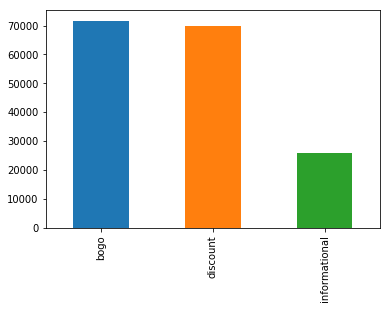

In [48]:
offers.offer_type.value_counts().plot(kind='bar')
plt.show()

In [49]:
portfolio

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [50]:
'3f207df678b143eea3cee63160fa8bed', '5a8bc65990b245e5a138643cd4eb9837'

('3f207df678b143eea3cee63160fa8bed', '5a8bc65990b245e5a138643cd4eb9837')

First lets check, can a user get the same offer twice?

In [51]:
transcript[transcript.event == 'offer received'][transcript.duplicated(['person', 'offer_value', 'time'])]

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,event,person,time,offer_type,offer_value


No one recieves more than one offer at a time

### Create offer_df that includes offers and detailes of persons and offer

In [52]:
offer_df = transcript_offers.merge(profile, how='left', on='user_id')

In [53]:
offer_df.columns

Index(['event', 'user_id', 'time', 'offer_id', 'age', 'gender', 'income',
       'join_year', 'join_month', 'join_day'],
      dtype='object')

In [54]:
portfolio.columns

Index(['difficulty', 'duration', 'offer_id', 'offer_type', 'reward', 'email',
       'mobile', 'social', 'web'],
      dtype='object')

In [55]:
offer_df = offer_df.merge(portfolio, how='left', on='offer_id')

In [56]:
offer_df.head()

,event,user_id,time,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,offer_type,reward,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,F,100000.0,2017,5,9,5,7,bogo,5,1,1,0,1
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,None,NaN,2017,8,4,20,10,discount,5,1,0,0,1
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,68,M,70000.0,2018,4,26,10,7,discount,2,1,1,0,1
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,118,None,NaN,2017,9,25,10,10,discount,2,1,1,1,1
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,118,None,NaN,2017,10,2,10,5,bogo,10,1,1,1,1


Since we have now a dataframe of each and every offer with time provided, we need to split them to different datasets where each offer is assigned a different time variable that will enable us to see how a customer reacted to an offer

In [57]:
# Dataframe of offers recieved
offer_received = offer_df[offer_df.event == 'offer received'].copy()
offer_received.drop(['event'], axis=1, inplace=True)
offer_received.rename(columns={'time':'time_received'}, inplace=True)
offer_received.head()

,user_id,time_received,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,offer_type,reward,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,F,100000.0,2017,5,9,5,7,bogo,5,1,1,0,1
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,None,NaN,2017,8,4,20,10,discount,5,1,0,0,1
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,68,M,70000.0,2018,4,26,10,7,discount,2,1,1,0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,118,None,NaN,2017,9,25,10,10,discount,2,1,1,1,1
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,118,None,NaN,2017,10,2,10,5,bogo,10,1,1,1,1


In [58]:
# Dataframe of offers viewed
offer_viewed = offer_df[offer_df.event == 'offer viewed'].copy()
offer_viewed.drop(['event'], axis=1, inplace=True)
offer_viewed.rename(columns={'time':'time_viewed'}, inplace=True)
offer_viewed.head()

,user_id,time_viewed,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,offer_type,reward,email,mobile,social,web
12650,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,65,M,53000.0,2018,2,9,5,5,bogo,5,1,1,1,1
12651,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837,53,O,52000.0,2017,9,16,0,3,informational,0,1,1,1,0
12652,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0,69,F,57000.0,2016,8,14,10,5,bogo,10,1,1,1,1
12653,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd,20,F,30000.0,2016,7,11,10,7,bogo,10,1,1,1,0
12654,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837,39,M,51000.0,2014,5,27,0,3,informational,0,1,1,1,0


In [59]:
# Dataframe of offers completed
offer_complete = offer_df[offer_df.event == 'offer completed'].copy()
offer_complete.drop(['event'], axis=1, inplace=True)
offer_complete.rename(columns={'time':'time_completed'}, inplace=True)
offer_complete.head()

,user_id,time_completed,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,offer_type,reward,email,mobile,social,web
12656,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,42,M,96000.0,2016,1,17,10,7,discount,2,1,1,0,1
12667,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,39,F,67000.0,2017,12,17,10,10,discount,2,1,1,1,1
12673,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,52,M,72000.0,2018,6,5,5,7,bogo,5,1,1,0,1
12683,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd,37,M,92000.0,2017,5,15,10,7,bogo,10,1,1,1,0
12687,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,48,M,62000.0,2015,9,3,10,5,bogo,10,1,1,1,1


Now we have 3 dataframes
- offer_received
- offer_viewed
- offer_complete

Now we can put them into a dataframe where we have each combination of person and offer time recieved, viewed and completed

In [60]:
len(offer_received), len(offer_viewed), len(offer_complete)

(76277, 57725, 33579)

This makes sense as number of recieved is higher than viewed and higher than completed

In [61]:
df_final = offer_received.merge(offer_viewed[['user_id', 'offer_id', 'time_viewed']], on=['user_id', 'offer_id'], how='left')

In [62]:
df_final = df_final.merge(offer_complete[['user_id', 'offer_id', 'time_completed']], on=['user_id', 'offer_id'], how='left')

In [63]:
df_final = df_final[['user_id', 'offer_id', 'age', 'gender', 'income',
                     'join_year', 'join_month', 'join_day', 'difficulty', 'duration',
                     'offer_type', 'reward', 'email', 'mobile', 'social', 'web', 'time_received',
                     'time_viewed', 'time_completed']]

In [64]:
df_final.head(10)

,user_id,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,offer_type,reward,email,mobile,social,web,time_received,time_viewed,time_completed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,F,100000.0,2017,5,9,5,7,bogo,5,1,1,0,1,0,6.0,132.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,None,NaN,2017,8,4,20,10,discount,5,1,0,0,1,0,6.0,NaN
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,None,NaN,2017,8,4,20,10,discount,5,1,0,0,1,0,624.0,NaN
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,68,M,70000.0,2018,4,26,10,7,discount,2,1,1,0,1,0,18.0,NaN
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,118,None,NaN,2017,9,25,10,10,discount,2,1,1,1,1,0,12.0,NaN
5,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,118,None,NaN,2017,9,25,10,10,discount,2,1,1,1,1,0,522.0,NaN
6,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,118,None,NaN,2017,10,2,10,5,bogo,10,1,1,1,1,0,84.0,NaN
7,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,65,M,53000.0,2018,2,9,5,5,bogo,5,1,1,1,1,0,0.0,60.0
8,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,65,M,53000.0,2018,2,9,5,5,bogo,5,1,1,1,1,0,0.0,600.0
9,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,65,M,53000.0,2018,2,9,5,5,bogo,5,1,1,1,1,0,504.0,60.0


In [65]:
df_final.shape

(115609, 19)

Now we have an awesome dataframe that has each and every offer sent to each and every person and the time they recieved and if viewed or completed with details of the person along with the offer details

### Check for duplicate record

In [66]:
df_final[df_final.duplicated(subset=['time_received', 'user_id', 'offer_id'])].head(10)

,user_id,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,offer_type,reward,email,mobile,social,web,time_received,time_viewed,time_completed
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,None,NaN,2017,8,4,20,10,discount,5,1,0,0,1,0,624.0,NaN
5,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,118,None,NaN,2017,9,25,10,10,discount,2,1,1,1,1,0,522.0,NaN
8,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,65,M,53000.0,2018,2,9,5,5,bogo,5,1,1,1,1,0,0.0,600.0
9,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,65,M,53000.0,2018,2,9,5,5,bogo,5,1,1,1,1,0,504.0,60.0
10,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,65,M,53000.0,2018,2,9,5,5,bogo,5,1,1,1,1,0,504.0,600.0
12,c4863c7985cf408faee930f111475da3,2298d6c36e964ae4a3e7e9706d1fb8c2,118,None,NaN,2017,8,24,7,7,discount,3,1,1,1,1,0,348.0,NaN
19,4b0da7e80e5945209a1fdddfe813dbe0,ae264e3637204a6fb9bb56bc8210ddfd,64,M,100000.0,2017,9,9,10,7,bogo,10,1,1,1,0,0,510.0,510.0
21,c27e0d6ab72c455a8bb66d980963de60,3f207df678b143eea3cee63160fa8bed,78,F,71000.0,2017,6,16,0,4,informational,0,1,1,0,1,0,348.0,NaN
23,d53717f5400c4e84affdaeda9dd926b3,0b1e1539f2cc45b7b9fa7c272da2e1d7,88,F,53000.0,2017,5,18,20,10,discount,5,1,0,0,1,0,30.0,624.0
24,d53717f5400c4e84affdaeda9dd926b3,0b1e1539f2cc45b7b9fa7c272da2e1d7,88,F,53000.0,2017,5,18,20,10,discount,5,1,0,0,1,0,690.0,30.0


In [67]:
len(df_final)

115609

In [68]:
# Drop all duplicates where the user, offer and time are identical
df_final.drop_duplicates(subset=['time_received', 'user_id', 'offer_id'], inplace=True)

In [69]:
df_final.shape

(76277, 19)

In [70]:
df_final.tail()

,user_id,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,offer_type,reward,email,mobile,social,web,time_received,time_viewed,time_completed
115604,d087c473b4d247ccb0abfef59ba12b0e,ae264e3637204a6fb9bb56bc8210ddfd,56,M,51000.0,2016,10,23,10,7,bogo,10,1,1,1,0,576,672.0,636.0
115605,cb23b66c56f64b109d673d5e56574529,2906b810c7d4411798c6938adc9daaa5,60,M,113000.0,2018,5,5,10,7,discount,2,1,1,0,1,576,NaN,156.0
115606,6d5f3a774f3d4714ab0c092238f3a1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,45,F,54000.0,2018,6,4,7,7,discount,3,1,1,1,1,576,588.0,NaN
115607,9dc1421481194dcd9400aec7c9ae6366,ae264e3637204a6fb9bb56bc8210ddfd,83,F,50000.0,2016,3,7,10,7,bogo,10,1,1,1,0,576,624.0,594.0
115608,e4052622e5ba45a8b96b59aba68cf068,3f207df678b143eea3cee63160fa8bed,62,F,82000.0,2017,7,22,0,4,informational,0,1,1,0,1,576,NaN,NaN


Now we have a clean dataset with no duplicate offers recieved by a customer

## Feature Engineering

#### Offer Expiry Date

In [71]:
# Offer expiry 
df_final['offer_expire'] = df_final.time_received + df_final.duration

#### Offer Classification

#### For an offer to be succesful, it has to be viewed and completed before it expires, this is the only way we are sure that an offer caused conversion

In [72]:
conditions = [((df_final.time_viewed >= df_final.time_received) & \
               (df_final.time_completed >= df_final.time_viewed) & \
               (df_final.offer_expire >= df_final.time_completed))]
choices = [1]

df_final['success'] = np.select(conditions, choices)

In [73]:
len(df_final[df_final['success'] == 1])

1243

#### Then we have those offers that are effective and here it can be any of the below:
- Viewed the offer before expiry and completed it after expiry
- Viewed the offer after expiry and completed it but it is important that the customer completed it after viewing it

Although these cases did not meet the deadline, we think they are effective as they might have influenced the customer

In [74]:
conditions = [((df_final.time_viewed >= df_final.time_received) & 
               (df_final.time_viewed <= df_final.offer_expire) & 
              ( (df_final.time_completed > df_final.offer_expire))
               
              )| \
              
              ((df_final.time_viewed >= df_final.time_received) & 
               (df_final.time_viewed > df_final.offer_expire)&
               (df_final.time_completed >= df_final.time_viewed)&
               (df_final.time_completed.notnull())
               
               )] 

choices = [1]

df_final['effective'] = np.select(conditions, choices)

In [75]:
len(df_final[df_final['effective'] == 1])

19720

In [76]:
conditions = [(df_final['success'] == 0) & (df_final['effective'] == 0)]
choices = [1]
df_final['failed'] = np.select(conditions, choices)

In [77]:
len(df_final[df_final['failed'] == 1])

55314

#### Then there are these cases that are covered in failed:

- Customer completing the offer before expiry but never viewing it
- Completing the offer then viewing it

There is even those whom whod have made the same purchase even if the offer was not sent but difficult to detect here

In [78]:
positive_df = df_final[(df_final.success == 1) | (df_final.effective == 1)]

In [79]:
positive_df.head()

,user_id,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,...,mobile,social,web,time_received,time_viewed,time_completed,offer_expire,success,effective,failed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,F,100000.0,2017,5,9,5,7,...,1,0,1,0,6.0,132.0,7,0,1,0
7,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,65,M,53000.0,2018,2,9,5,5,...,1,1,1,0,0.0,60.0,5,0,1,0
18,4b0da7e80e5945209a1fdddfe813dbe0,ae264e3637204a6fb9bb56bc8210ddfd,64,M,100000.0,2017,9,9,10,7,...,1,1,0,0,102.0,510.0,7,0,1,0
22,d53717f5400c4e84affdaeda9dd926b3,0b1e1539f2cc45b7b9fa7c272da2e1d7,88,F,53000.0,2017,5,18,20,10,...,0,0,1,0,30.0,30.0,10,0,1,0
26,f806632c011441378d4646567f357a21,fafdcd668e3743c1bb461111dcafc2a4,42,M,69000.0,2013,8,11,10,10,...,1,1,1,0,18.0,126.0,10,0,1,0


Now we have this great dataframe, I want to merge it with the transaction amount and as per my research and help from other projects and the study hub, the best thing I can do is merge the tables then check when spending occured at the same time an offer was either success or effective in the positive_df dataframe

In [80]:
df_full = positive_df.merge(transcript_amount, on='user_id', how='left')

In [81]:
df_full.head()

,user_id,offer_id,age,gender,income,join_year,join_month,join_day,difficulty,duration,...,web,time_received,time_viewed,time_completed,offer_expire,success,effective,failed,time_spent,amount
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,F,100000.0,2017,5,9,5,7,...,1,0,6.0,132.0,7,0,1,0,132,19.89
1,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,F,100000.0,2017,5,9,5,7,...,1,0,6.0,132.0,7,0,1,0,144,17.78
2,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,F,100000.0,2017,5,9,5,7,...,1,0,6.0,132.0,7,0,1,0,222,19.67
3,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,F,100000.0,2017,5,9,5,7,...,1,0,6.0,132.0,7,0,1,0,240,29.72
4,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,F,100000.0,2017,5,9,5,7,...,1,0,6.0,132.0,7,0,1,0,378,23.93


In [82]:
len(df_full)

207752

In this dataframe, we have for each and every user with offer, all the ammounts spent but this does not mean that each of these offers has this value, to get which of these offers might have a monetory value we need to condition on the below:

- Spending time shall be less than the time completed and after the offer has been viewed
- Spending time shall be less than the expiry and after the offer has been viewed

In [83]:
df = df_full[(df_full.time_spent <= df_full.time_completed) & (df_full.time_spent >=  df_full.time_viewed) |
       (df_full.time_spent <= df_full.offer_expire) & (df_full.time_spent >=  df_full.time_viewed)]

In [84]:
df.isnull().sum()

user_id              0
offer_id             0
age                  0
gender            3058
income            3058
join_year            0
join_month           0
join_day             0
difficulty           0
duration             0
offer_type           0
reward               0
email                0
mobile               0
social               0
web                  0
time_received        0
time_viewed          0
time_completed       0
offer_expire         0
success              0
effective            0
failed               0
time_spent           0
amount               0
dtype: int64

In [85]:
df.shape, df.user_id.nunique()

((32396, 25), 11568)

Since our goal is to segment the customers we need to do the below:

- Extract as much variables as possible from the offers
- Have the dataframe where each line is a customer
- Fill the missing values in age and income
- Conduct an unpservised learning customer segmentation

In [86]:
# Number of offers succesful and effective by person
df_1 = df.groupby(['user_id', 'offer_id'])['success', 'effective'].sum().reset_index()
df_1.rename(columns={'success':'num_succ', 'effective':'num_effect'}, inplace=True)
df_1.head()

,user_id,offer_id,num_succ,num_effect
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,0,1


In [87]:
df.amount = df.amount.astype(int).copy()

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [88]:
# Total and average money spent by customer on each offer
df_2 = df.groupby(['user_id', 'offer_id']).agg({'amount':['sum','mean']})
df_2.columns = df_2.columns.droplevel(0)
df_2.rename(columns={'sum':'total_spent', 'mean':'avg_spent'}, inplace=True)
df_2 = df_2.reset_index()

In [89]:
df_2.head()

,user_id,offer_id,total_spent,avg_spent
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,22,22.0
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,11,11.0
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,22,22.0
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,17,17.0
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,17,17.0


In [90]:
# Difference between time the offer was received and completed
df_3 = df[['user_id', 'offer_id', 'time_completed', 'time_received']]
df_3['time_diff'] = df.time_completed - df.time_received
df_3 = df_3.groupby(['user_id', 'offer_id']).time_diff.mean().reset_index().rename(columns = {'time_diff':'avg_response_diff'})

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [91]:
df_3.head()

,user_id,offer_id,avg_response_diff
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,168.0
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,84.0
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,72.0
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,102.0
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,54.0


In [92]:
offer_received.columns

Index(['user_id', 'time_received', 'offer_id', 'age', 'gender', 'income',
       'join_year', 'join_month', 'join_day', 'difficulty', 'duration',
       'offer_type', 'reward', 'email', 'mobile', 'social', 'web'],
      dtype='object')

In [93]:
# Number of offers received by each customer
df_4 = offer_received.groupby(['user_id', 'offer_id']).time_received.count().reset_index()
df_4.rename(columns = {'time_received':'num_offer_rec'}, inplace=True)

Now we have some stats on the users in respect to the offers, but to add these stats back to the SBX customer profile, we need to remove the duplicates by splitting each stat by offer

In [94]:
# First lets merge the 4 dataframes created above
df_a = df_1.merge(df_2, on=['user_id', 'offer_id'], how='left', validate='one_to_one')
df_b = df_a.merge(df_3, on=['user_id', 'offer_id'], how='left', validate='one_to_one')
df_temp = df_b.merge(df_4, on=['user_id', 'offer_id'], how='left', validate='one_to_one')

In [95]:
df_temp.columns

Index(['user_id', 'offer_id', 'num_succ', 'num_effect', 'total_spent',
       'avg_spent', 'avg_response_diff', 'num_offer_rec'],
      dtype='object')

In [96]:
df_temp.offer_id.nunique()

8

Now we have 8 offers, which offers are missing?

In [97]:
portfolio[~portfolio.offer_id.isin(df_temp.offer_id)]

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0


We can see that these type of offers, since they don't allow for an action on behalf the customer where removed from the dataset as they assist very little in understanding the customers since the customer made no action that is worth recording or noting

In [98]:
le = preprocessing.LabelEncoder()

In [99]:
df_temp.offer_id = le.fit_transform(df_temp.offer_id)

In [100]:
df_temp.head()

,user_id,offer_id,num_succ,num_effect,total_spent,avg_spent,avg_response_diff,num_offer_rec
0,0011e0d4e6b944f998e987f904e8c1e5,0,0,1,22,22.0,168.0,1
1,0011e0d4e6b944f998e987f904e8c1e5,1,0,1,11,11.0,84.0,1
2,0011e0d4e6b944f998e987f904e8c1e5,4,0,1,22,22.0,72.0,1
3,0020c2b971eb4e9188eac86d93036a77,3,0,1,17,17.0,102.0,1
4,0020c2b971eb4e9188eac86d93036a77,7,0,1,17,17.0,54.0,2


In [101]:
offer_received.offer_id.value_counts()

9b98b8c7a33c4b65b9aebfe6a799e6d9    7677
0b1e1539f2cc45b7b9fa7c272da2e1d7    7668
ae264e3637204a6fb9bb56bc8210ddfd    7658
2298d6c36e964ae4a3e7e9706d1fb8c2    7646
2906b810c7d4411798c6938adc9daaa5    7632
5a8bc65990b245e5a138643cd4eb9837    7618
3f207df678b143eea3cee63160fa8bed    7617
fafdcd668e3743c1bb461111dcafc2a4    7597
4d5c57ea9a6940dd891ad53e9dbe8da0    7593
f19421c1d4aa40978ebb69ca19b0e20d    7571
Name: offer_id, dtype: int64

In [102]:
df_temp.offer_id.value_counts()

7    4033
1    3820
6    3129
3    2436
5    2314
4    1922
2    1891
0    1207
Name: offer_id, dtype: int64

In [103]:
offer_0 = df_temp[df_temp.offer_id == 0]
offer_1 = df_temp[df_temp.offer_id == 1]
offer_2 = df_temp[df_temp.offer_id == 2]
offer_3 = df_temp[df_temp.offer_id == 3]
offer_4 = df_temp[df_temp.offer_id == 4]
offer_5 = df_temp[df_temp.offer_id == 5]
offer_6 = df_temp[df_temp.offer_id == 6]
offer_7 = df_temp[df_temp.offer_id == 7]

In [104]:
offer_0['offer_0_succ_ratio'] = offer_0['num_succ']/offer_0['num_offer_rec']
offer_0['offer_0_effect_ratio'] = offer_0['num_effect']/offer_0['num_offer_rec']

offer_0.rename(columns={'num_succ':'num_0_succ', 'num_effect':'num_0_effect', 'total_spent':'total_0_spent',
                        'avg_spent':'avg_0_spent', 'avg_response_diff':'avg_response_0_diff', 'num_offer_rec':'num_offer_0_rec'}, inplace=True)

offer_0.drop('offer_id', axis=1,inplace=True)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

In [105]:
offer_0.head(10)

,user_id,num_0_succ,num_0_effect,total_0_spent,avg_0_spent,avg_response_0_diff,num_offer_0_rec,offer_0_succ_ratio,offer_0_effect_ratio
0,0011e0d4e6b944f998e987f904e8c1e5,0,1,22,22.0,168.0,1,0.0,1.0
19,0091d2b6a5ea4defaa8393e4e816db60,0,1,27,27.0,132.0,1,0.0,1.0
36,00c20a9202d5475190b31a24de6fb06d,0,2,35,17.5,90.0,1,0.0,2.0
58,00e52682848542c3a6f59b7824e9a5c5,0,2,22,11.0,216.0,1,0.0,2.0
74,013f2c82889f4641a9b847a48861cce0,1,0,22,22.0,0.0,1,1.0,0.0
81,0157e63b39c5456393026c6c03f3d84a,0,1,27,27.0,66.0,1,0.0,1.0
89,01633b71b3a2457aa7d35d8bcc3afb5a,0,1,24,24.0,96.0,1,0.0,1.0
148,020d72e77c704c42bb0a858c1aaa3bcd,0,2,27,13.5,24.0,1,0.0,2.0
151,0215efe5136d4a038cb81eae92d59368,0,2,27,13.5,198.0,1,0.0,2.0
187,02a3aa431c1047be8eafec3dcd6b5fd0,0,1,25,25.0,144.0,1,0.0,1.0


In [106]:
offer_1['offer_1_succ_ratio'] = offer_1['num_succ']/offer_1['num_offer_rec']
offer_1['offer_1_effect_ratio'] = offer_1['num_effect']/offer_1['num_offer_rec']

offer_1.rename(columns={'num_succ':'num_1_succ', 'num_effect':'num_1_effect', 'total_spent':'total_1_spent',
                        'avg_spent':'avg_1_spent', 'avg_response_diff':'avg_response_1_diff', 'num_offer_rec':'num_offer_1_rec'}, inplace=True)

offer_1.drop('offer_id', axis=1,inplace=True)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

In [107]:
offer_2['offer_2_succ_ratio'] = offer_2['num_succ']/offer_2['num_offer_rec']
offer_2['offer_2_effect_ratio'] = offer_2['num_effect']/offer_2['num_offer_rec']

offer_2.rename(columns={'num_succ':'num_2_succ', 'num_effect':'num_2_effect', 'total_spent':'total_2_spent',
                        'avg_spent':'avg_2_spent', 'avg_response_diff':'avg_response_2_diff', 'num_offer_rec':'num_offer_2_rec'}, inplace=True)

offer_2.drop('offer_id', axis=1,inplace=True)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

In [108]:
offer_3['offer_3_succ_ratio'] = offer_3['num_succ']/offer_3['num_offer_rec']
offer_3['offer_3_effect_ratio'] = offer_3['num_effect']/offer_3['num_offer_rec']

offer_3.rename(columns={'num_succ':'num_3_succ', 'num_effect':'num_3_effect', 'total_spent':'total_3_spent',
                        'avg_spent':'avg_3_spent', 'avg_response_diff':'avg_response_3_diff', 'num_offer_rec':'num_offer_3_rec'}, inplace=True)

offer_3.drop('offer_id', axis=1,inplace=True)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

In [109]:
offer_4['offer_4_succ_ratio'] = offer_4['num_succ']/offer_4['num_offer_rec']
offer_4['offer_4_effect_ratio'] = offer_4['num_effect']/offer_4['num_offer_rec']

offer_4.rename(columns={'num_succ':'num_4_succ', 'num_effect':'num_4_effect', 'total_spent':'total_4_spent',
                        'avg_spent':'avg_4_spent', 'avg_response_diff':'avg_response_4_diff', 'num_offer_rec':'num_offer_4_rec'}, inplace=True)

offer_4.drop('offer_id', axis=1,inplace=True)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

In [110]:
offer_5['offer_5_succ_ratio'] = offer_5['num_succ']/offer_5['num_offer_rec']
offer_5['offer_5_effect_ratio'] = offer_5['num_effect']/offer_5['num_offer_rec']

offer_5.rename(columns={'num_succ':'num_5_succ', 'num_effect':'num_5_effect', 'total_spent':'total_5_spent',
                        'avg_spent':'avg_5_spent', 'avg_response_diff':'avg_response_5_diff', 'num_offer_rec':'num_offer_5_rec'}, inplace=True)

offer_5.drop('offer_id', axis=1,inplace=True)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

In [111]:
offer_6['offer_6_succ_ratio'] = offer_6['num_succ']/offer_6['num_offer_rec']
offer_6['offer_6_effect_ratio'] = offer_6['num_effect']/offer_6['num_offer_rec']

offer_6.rename(columns={'num_succ':'num_6_succ', 'num_effect':'num_6_effect', 'total_spent':'total_6_spent',
                        'avg_spent':'avg_6_spent', 'avg_response_diff':'avg_response_6_diff', 'num_offer_rec':'num_offer_6_rec'}, inplace=True)

offer_6.drop('offer_id', axis=1,inplace=True)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

In [112]:
offer_7['offer_7_succ_ratio'] = offer_7['num_succ']/offer_7['num_offer_rec']
offer_7['offer_7_effect_ratio'] = offer_7['num_effect']/offer_7['num_offer_rec']

offer_7.rename(columns={'num_succ':'num_7_succ', 'num_effect':'num_7_effect', 'total_spent':'total_7_spent',
                        'avg_spent':'avg_7_spent', 'avg_response_diff':'avg_response_7_diff', 'num_offer_rec':'num_offer_7_rec'}, inplace=True)

offer_7.drop('offer_id', axis=1,inplace=True)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

In [113]:
profile_all = profile.merge(offer_0, on='user_id', how='left')
profile_all = profile_all.merge(offer_1, on='user_id', how='left')
profile_all = profile_all.merge(offer_2, on='user_id', how='left')
profile_all = profile_all.merge(offer_3, on='user_id', how='left')
profile_all = profile_all.merge(offer_4, on='user_id', how='left')
profile_all = profile_all.merge(offer_5, on='user_id', how='left')
profile_all = profile_all.merge(offer_6, on='user_id', how='left')
profile_all = profile_all.merge(offer_7, on='user_id', how='left')

In [114]:
profile_all.head()

,age,gender,user_id,income,join_year,join_month,join_day,num_0_succ,num_0_effect,total_0_spent,...,offer_6_succ_ratio,offer_6_effect_ratio,num_7_succ,num_7_effect,total_7_spent,avg_7_spent,avg_response_7_diff,num_offer_7_rec,offer_7_succ_ratio,offer_7_effect_ratio
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,NaN,NaN,NaN,...,NaN,NaN,0.0,5.0,8.0,1.6,144.0,2.0,0.0,2.5
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
profile_all[profile_all.user_id.duplicated()]

,age,gender,user_id,income,join_year,join_month,join_day,num_0_succ,num_0_effect,total_0_spent,...,offer_6_succ_ratio,offer_6_effect_ratio,num_7_succ,num_7_effect,total_7_spent,avg_7_spent,avg_response_7_diff,num_offer_7_rec,offer_7_succ_ratio,offer_7_effect_ratio


In [116]:
profile_all.isnull().sum().head(10)

age                  0
gender            2175
user_id              0
income            2175
join_year            0
join_month           0
join_day             0
num_0_succ       15793
num_0_effect     15793
total_0_spent    15793
dtype: int64

We can see that we are back to the same profile dataset we started with but with different columns that are more helpful in inputing missing fields and segmenting our customers

In [117]:
cols = ['user_id', 'join_year', 'join_month',
       'join_day', 'num_0_succ', 'num_0_effect', 'total_0_spent',
       'avg_0_spent', 'avg_response_0_diff', 'num_offer_0_rec',
       'offer_0_succ_ratio', 'offer_0_effect_ratio', 'num_1_succ',
       'num_1_effect', 'total_1_spent', 'avg_1_spent', 'avg_response_1_diff',
       'num_offer_1_rec', 'offer_1_succ_ratio', 'offer_1_effect_ratio',
       'num_2_succ', 'num_2_effect', 'total_2_spent', 'avg_2_spent',
       'avg_response_2_diff', 'num_offer_2_rec', 'offer_2_succ_ratio',
       'offer_2_effect_ratio', 'num_3_succ', 'num_3_effect', 'total_3_spent',
       'avg_3_spent', 'avg_response_3_diff', 'num_offer_3_rec',
       'offer_3_succ_ratio', 'offer_3_effect_ratio', 'num_4_succ',
       'num_4_effect', 'total_4_spent', 'avg_4_spent', 'avg_response_4_diff',
       'num_offer_4_rec', 'offer_4_succ_ratio', 'offer_4_effect_ratio',
       'num_5_succ', 'num_5_effect', 'total_5_spent', 'avg_5_spent',
       'avg_response_5_diff', 'num_offer_5_rec', 'offer_5_succ_ratio',
       'offer_5_effect_ratio', 'num_6_succ', 'num_6_effect', 'total_6_spent',
       'avg_6_spent', 'avg_response_6_diff', 'num_offer_6_rec',
       'offer_6_succ_ratio', 'offer_6_effect_ratio', 'num_7_succ',
       'num_7_effect', 'total_7_spent', 'avg_7_spent', 'avg_response_7_diff',
       'num_offer_7_rec', 'offer_7_succ_ratio', 'offer_7_effect_ratio']

In [118]:
profile_all[cols] = profile_all[cols].fillna(0)

In [119]:
profile_all.head()

,age,gender,user_id,income,join_year,join_month,join_day,num_0_succ,num_0_effect,total_0_spent,...,offer_6_succ_ratio,offer_6_effect_ratio,num_7_succ,num_7_effect,total_7_spent,avg_7_spent,avg_response_7_diff,num_offer_7_rec,offer_7_succ_ratio,offer_7_effect_ratio
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,8.0,1.6,144.0,2.0,0.0,2.5
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
profile_all['total_num_suc_offers'] = profile_all.num_0_succ + profile_all.num_1_succ + profile_all.num_2_succ + profile_all.num_3_succ +\
profile_all.num_4_succ + profile_all.num_5_succ + profile_all.num_6_succ + profile_all.num_7_succ

In [121]:
profile_all['total_num_effect_offers'] = profile_all.num_0_effect + profile_all.num_1_effect + profile_all.num_2_effect + profile_all.num_3_effect +\
profile_all.num_4_effect + profile_all.num_5_effect + profile_all.num_6_effect + profile_all.num_7_effect

In [122]:
profile_all['total_spent'] = profile_all.total_0_spent + profile_all.total_1_spent + profile_all.total_2_spent + profile_all.total_3_spent +\
profile_all.total_4_spent + profile_all.total_5_spent + profile_all.total_6_spent + profile_all.total_7_spent

In [123]:
profile_all['total_num_offers'] = profile_all.num_offer_0_rec + profile_all.num_offer_1_rec + profile_all.num_offer_2_rec + \
profile_all.num_offer_3_rec +\
profile_all.num_offer_4_rec + profile_all.num_offer_5_rec + profile_all.num_offer_6_rec + profile_all.num_offer_7_rec

In [124]:
profile_all['total_num_succesful_offers'] = profile_all.offer_0_succ_ratio + profile_all.offer_1_succ_ratio + profile_all.offer_2_succ_ratio + \
profile_all.offer_3_succ_ratio +\
profile_all.offer_4_succ_ratio + profile_all.offer_5_succ_ratio + profile_all.offer_6_succ_ratio + profile_all.offer_7_succ_ratio

In [125]:
profile_all['total_num_effective_offers'] = profile_all.offer_4_effect_ratio + profile_all.offer_4_effect_ratio + profile_all.offer_4_effect_ratio + \
profile_all.offer_4_effect_ratio +\
profile_all.offer_4_effect_ratio + profile_all.offer_4_effect_ratio + profile_all.offer_4_effect_ratio + profile_all.offer_4_effect_ratio

In [126]:
profile_all.head()

,age,gender,user_id,income,join_year,join_month,join_day,num_0_succ,num_0_effect,total_0_spent,...,avg_response_7_diff,num_offer_7_rec,offer_7_succ_ratio,offer_7_effect_ratio,total_num_suc_offers,total_num_effect_offers,total_spent,total_num_offers,total_num_succesful_offers,total_num_effective_offers
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,12,0.0,0.0,0.0,...,144.0,2.0,0.0,2.5,0.0,8.0,15.0,3.0,0.0,0.0
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,15,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,12,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,9,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,40.0,2.0,0.0,8.0
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now there are enough features to predict the missing datapoints and segment the customers 

In [127]:
profile_all.isnull().sum()

age                              0
gender                        2175
user_id                          0
income                        2175
join_year                        0
join_month                       0
join_day                         0
num_0_succ                       0
num_0_effect                     0
total_0_spent                    0
avg_0_spent                      0
avg_response_0_diff              0
num_offer_0_rec                  0
offer_0_succ_ratio               0
offer_0_effect_ratio             0
num_1_succ                       0
num_1_effect                     0
total_1_spent                    0
avg_1_spent                      0
avg_response_1_diff              0
num_offer_1_rec                  0
offer_1_succ_ratio               0
offer_1_effect_ratio             0
num_2_succ                       0
num_2_effect                     0
total_2_spent                    0
avg_2_spent                      0
avg_response_2_diff              0
num_offer_2_rec     

### Predict Gender, Age, Income

In [128]:
def display_all(df):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
        display(df)

In [129]:
# Convert the user id to a numeric encoded variable
profile_all.user_id = le.fit_transform(profile_all.user_id)

In [130]:
# Since same records has the missing income and gender, I will split the data 
profile_null = profile_all[profile_all.gender.isnull()]
profile_clean = profile_all[~profile_all.gender.isnull()]

In [131]:
profile_clean.gender = profile_clean.gender.factorize()[0]

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


#### Gender

In [132]:
data = profile_clean.drop(['gender', 'age', 'income'], axis=1) 
y = profile_clean.gender

In [133]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

In [134]:
# Use randomforestclassifier to classify gender
model_gender = RandomForestClassifier(n_jobs=-1, random_state = 42)
model_gender.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [135]:
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

In [136]:
preds = np.stack([t.predict(X_test) for t in model_gender.estimators_])
preds[:,0], np.std(preds[:,0]), y_test.iloc[0]

(array([0., 0., 0., 1., 0., 0., 1., 1., 1., 1.]), 0.5, 0)

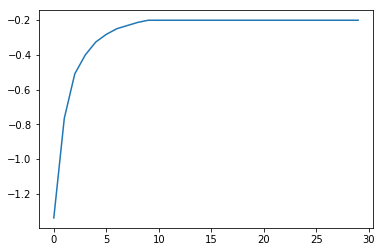

In [137]:
plt.plot([r2_score(y_test, np.std(preds[:i+1], axis=0)) for i in range(30)]);

#### Age

In [138]:
y = profile_clean.age

In [139]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

In [140]:
# Use randomforestclassifier to classify gender
model_age = RandomForestRegressor(n_jobs=-1, random_state = 42)
model_age.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [141]:
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

In [142]:
preds = np.stack([t.predict(X_test) for t in model_age.estimators_])
preds[:,0], np.std(preds[:,0]), y_test.iloc[0]

(array([56., 66., 83., 18., 67., 70., 63., 66., 57., 59.]),
 15.957756734578956,
 52)

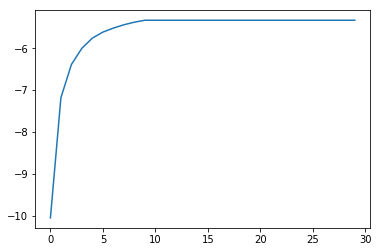

In [143]:
plt.plot([r2_score(y_test, np.std(preds[:i+1], axis=0)) for i in range(30)]);

#### Income

In [144]:
y = profile_clean.income

In [145]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

In [146]:
# Use randomforestclassifier to classify gender
model_income = RandomForestRegressor(n_jobs=-1, random_state = 42)
model_income.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [147]:
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

In [148]:
preds = np.stack([t.predict(X_test) for t in model_income.estimators_])
preds[:,0], np.std(preds[:,0]), y_test.iloc[0]

(array([ 64000.,  77000., 117000.,  87000.,  85000.,  67000.,  87000.,
         71000.,  85000.,  61000.]), 15469.001260585635, 79000.0)

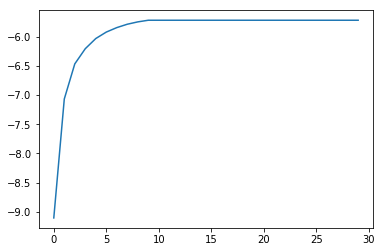

In [149]:
plt.plot([r2_score(y_test, np.std(preds[:i+1], axis=0)) for i in range(30)]);

## Putting the predicted variables into a the dataframe

In [150]:
profile_temp = profile_null.drop(['age', 'gender', 'income'], axis=1)

In [151]:
profile_new = profile_null.drop(['age', 'gender', 'income'], axis=1)

In [152]:
profile_new['gender'] = model_gender.predict(profile_temp)

In [153]:
profile_new['age'] = model_age.predict(profile_temp)

In [154]:
profile_new['income'] = model_income.predict(profile_temp)

In [155]:
profile_new.head()

,user_id,join_year,join_month,join_day,num_0_succ,num_0_effect,total_0_spent,avg_0_spent,avg_response_0_diff,num_offer_0_rec,...,offer_7_effect_ratio,total_num_suc_offers,total_num_effect_offers,total_spent,total_num_offers,total_num_succesful_offers,total_num_effective_offers,gender,age,income
0,6961,2017,2,12,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,8.0,15.0,3.0,0.0,0.0,1,51.8,40100.0
2,3746,2018,7,12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,58.5,57100.0
4,10735,2017,8,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,51.5,50200.0
6,9524,2017,9,25,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,60.3,51200.0
7,6939,2017,10,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,65.1,70200.0


In [156]:
profile_new.shape, profile_clean.shape

((2175, 77), (14825, 77))

In [157]:
org_col = list(profile_clean.columns)

In [158]:
profile_new = profile_new[org_col]

In [159]:
# Putting back the final dataframe
data_sbx =  pd.concat([profile_new, profile_clean])
data_sbx.head()

,age,gender,user_id,income,join_year,join_month,join_day,num_0_succ,num_0_effect,total_0_spent,...,avg_response_7_diff,num_offer_7_rec,offer_7_succ_ratio,offer_7_effect_ratio,total_num_suc_offers,total_num_effect_offers,total_spent,total_num_offers,total_num_succesful_offers,total_num_effective_offers
0,51.8,1,6961,40100.0,2017,2,12,0.0,0.0,0.0,...,144.0,2.0,0.0,2.5,0.0,8.0,15.0,3.0,0.0,0.0
2,58.5,0,3746,57100.0,2018,7,12,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,51.5,1,10735,50200.0,2017,8,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,60.3,1,9524,51200.0,2017,9,25,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,65.1,1,6939,70200.0,2017,10,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Applying Standard Scaler

In [161]:
scaler = StandardScaler().fit(data_sbx)
scaled_df  = scaler.transform(data_sbx)
sbx_scaled = pd.DataFrame(scaled_df, columns=data_sbx.columns)

In [163]:
sbx_scaled.head()

,age,gender,user_id,income,join_year,join_month,join_day,num_0_succ,num_0_effect,total_0_spent,...,avg_response_7_diff,num_offer_7_rec,offer_7_succ_ratio,offer_7_effect_ratio,total_num_suc_offers,total_num_effect_offers,total_spent,total_num_offers,total_num_succesful_offers,total_num_effective_offers
0,-0.133582,0.747058,-0.313501,-1.172434,0.309955,-1.343142,-0.442293,-0.034757,-0.209826,-0.131856,...,2.267843,2.980557,-0.117041,2.269515,-0.261748,2.811226,-0.210903,1.035925,-0.255124,-0.269517
1,0.271534,-1.210098,-0.968624,-0.350972,1.159148,0.090757,-0.442293,-0.034757,-0.209826,-0.131856,...,-0.385695,-0.510158,-0.117041,-0.399410,-0.261748,-0.832827,-0.477695,-1.086190,-0.255124,-0.269517
2,-0.151722,0.747058,0.455529,-0.684389,0.309955,0.377537,-1.353960,-0.034757,-0.209826,-0.131856,...,-0.385695,-0.510158,-0.117041,-0.399410,-0.261748,-0.832827,-0.477695,-1.086190,-0.255124,-0.269517
3,0.380372,0.747058,0.208763,-0.636068,0.309955,0.664317,1.039167,-0.034757,-0.209826,-0.131856,...,-0.385695,-0.510158,-0.117041,-0.399410,-0.261748,-0.832827,-0.477695,-1.086190,-0.255124,-0.269517
4,0.670604,0.747058,-0.317984,0.282036,0.309955,0.951097,-1.581877,-0.034757,-0.209826,-0.131856,...,-0.385695,-0.510158,-0.117041,-0.399410,-0.261748,-0.832827,-0.477695,-1.086190,-0.255124,-0.269517


## Performing Dimensionality Reduction

In [165]:
pca = PCA()
sbx_pca = pca.fit(sbx_scaled)

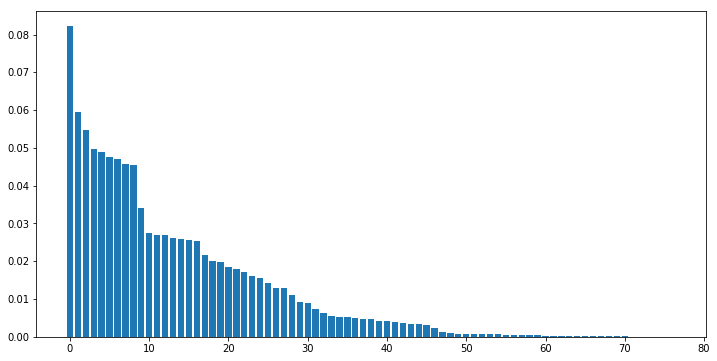

In [166]:
p_comp =np.arange(len(sbx_pca.explained_variance_ratio_))
var = sbx_pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.bar(p_comp, var)
plt.show()

In [173]:
sbx_pca.explained_variance_ratio_[:30].sum()

0.9071216295630533

In [174]:
# Perform PCA with 30 components
pca = PCA(n_components=30).fit(sbx_scaled)
sbx_pca = pca.transform(sbx_scaled)

In [175]:
sbx_pca.shape

(17000, 30)

In [176]:
def PC_W(df, n_comp):
    return pd.DataFrame(pca.components_[n_comp],index=df.columns, columns=['PC-'+str(n_comp+1)]).\
sort_values('PC-'+str(n_comp+1),ascending=False)

In [177]:
PC_W(sbx_scaled, 0).head()

,PC-1
total_num_offers,0.331588
total_spent,0.277575
total_num_effect_offers,0.272600
num_offer_4_rec,0.175095
total_num_effective_offers,0.167677


In [178]:
PC_W(sbx_scaled, 0).tail()

,PC-1
join_month,0.013608
join_day,0.002865
user_id,-0.002403
gender,-0.043116
join_year,-0.091031


In [179]:
PC_W(sbx_scaled, 1).head()

,PC-2
num_4_effect,0.374720
total_num_effective_offers,0.372749
offer_4_effect_ratio,0.372749
avg_response_4_diff,0.337034
num_offer_4_rec,0.334464


In [180]:
PC_W(sbx_scaled, 1).tail()

,PC-2
num_offer_5_rec,-0.085413
total_2_spent,-0.086092
total_num_succesful_offers,-0.088425
total_num_suc_offers,-0.089387
total_spent,-0.099082


In [181]:
PC_W(sbx_scaled, 2).head()

,PC-3
num_7_effect,0.271777
total_num_effect_offers,0.269403
offer_7_effect_ratio,0.262328
avg_response_7_diff,0.227335
num_1_effect,0.220872


In [182]:
PC_W(sbx_scaled, 2).tail()

,PC-3
offer_1_succ_ratio,-0.137457
num_7_succ,-0.138928
offer_7_succ_ratio,-0.138958
total_num_succesful_offers,-0.306833
total_num_suc_offers,-0.307321


## Interpretation of the Principal Components

In the first prinicpal component, it is 

## Clustering

In [185]:
# Over a number of different cluster counts...

cluster_dict = {}

clusters = [2, 3, 5, 6, 8, 9, 10, 13, 15, 18]
    # run k-means clustering on the data and...
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, random_state=0).fit(sbx_pca)
    
    # compute the average within-cluster distances.
    score = abs(kmeans.score(sbx_pca))
    cluster_dict[cluster] = score
    print(cluster, 'Cluster has a score of: ', score)

2 Cluster has a score of:  1118283.6892817102
3 Cluster has a score of:  1060429.0101113517
5 Cluster has a score of:  969220.3461787635
6 Cluster has a score of:  936830.2252148574
8 Cluster has a score of:  865041.01508954
9 Cluster has a score of:  831563.5377217495
10 Cluster has a score of:  808082.8756675409
13 Cluster has a score of:  714527.3027648415
15 Cluster has a score of:  649915.6121933826
18 Cluster has a score of:  577276.0735466809


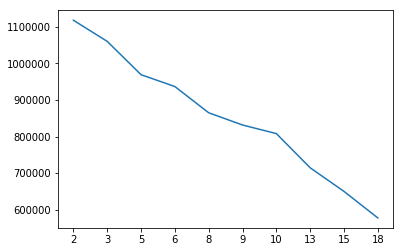

In [186]:
plt.plot(range(len(cluster_dict)), list(cluster_dict.values()))
plt.xticks(range(len(cluster_dict)), list(cluster_dict.keys()))
plt.show()

In [190]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(sbx_pca)
sbx_cluster = kmeans.predict(sbx_pca)

After choosing several sizes for the clusters, I decided to take 8 clusters because if we look at how the score was decreasing we notice that it was decreasing at a decreasing rate, but at 8 clusters and beyond the rate diminishes and any additional number of clusters will be useless as the distances is barely decreasing.

## Putting the Profile of customers back

In [204]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

cust_map = pd.DataFrame()
cust_map['data_index'] = profile.index.values
cust_map['cluster'] = sbx_cluster+1

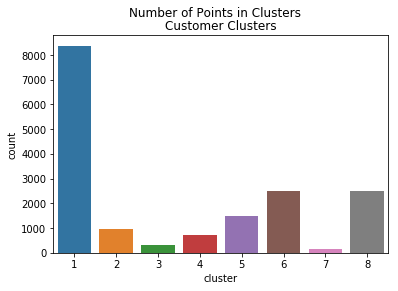

In [210]:
fig, (ax1) = plt.subplots(1)
fig.suptitle("Number of Points in Clusters")
ax1.title.set_text('Customer Clusters')
sns.countplot(cust_map.cluster, ax=ax1)
plt.show()

In [211]:
# Transforming cluster 1 back to its original values in the population dataframe with low nulls
overrepresented = list(pca.inverse_transform(kmeans.cluster_centers_[0]))
over_map = pd.DataFrame()
over_map['features'] = sbx_scaled.columns
over_map['Values'] = overrepresented
over_map.sort_values('Values', ascending=False).head()

,features,Values
4,join_year,0.159805
1,gender,0.048524
6,join_day,0.001822
2,user_id,0.000338
59,avg_response_6_diff,-0.015474


In [212]:
# What kinds of people are part of a cluster that is underrepresented
underpresented = list(pca.inverse_transform(kmeans.cluster_centers_[6]))
under_map = pd.DataFrame()
under_map['features'] = sbx_scaled.columns
under_map['Values'] = underpresented
under_map.sort_values('Values', ascending=False).head()

,features,Values
55,num_6_succ,10.606627
61,offer_6_succ_ratio,10.590148
71,total_num_suc_offers,3.497733
75,total_num_succesful_offers,3.480994
60,num_offer_6_rec,1.988266
